In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from collections import defaultdict
import torchvision.models as models
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import random
import pickle
import razdel
import torch
import json
import re

from dataset import DecoderDataset
from vocabulary import Vectorizer
from autoencoder import Autoencoder
from decoder import Decoder, AttentionDecoder

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [2]:
datasets_train_paths = [
    'D:/Вера/Диплом/Датасеты/flicker_train.pickle',
    'D:/Вера/Диплом/Датасеты/GCC_train.pickle',
    'D:/Вера/Диплом/Датасеты/coco_train.pickle',
]
dataset_test_paths = [
    'D:/Вера/Диплом/Датасеты/all_test.pickle'
]
all_captions_path = 'D:/Вера/Диплом/all_captions.csv'

In [3]:
vectorizer = Vectorizer(pd.read_csv(all_captions_path)['translations'])

In [4]:
decoder_dataset = DecoderDataset(datasets_train_paths, vectorizer)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:24<00:00, 88.08s/it]


In [5]:
test_decoder_dataset = DecoderDataset(dataset_test_paths, vectorizer)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.02s/it]


In [6]:
loader = DataLoader(decoder_dataset, batch_size=batch_size, shuffle=True)

In [25]:
embed_size = 512
hidden_size = 512
vocab_size = len(vectorizer)
num_layers = 1
learning_rate = 1e-3
num_epochs = 100

model = Decoder(embed_size, hidden_size, vocab_size, num_layers, vectorizer).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.unknown_idx)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

name = "captioning_exp_all_datasets"

config = {
    "name": f"{name}_config.json",
    "datasets": datasets_train_paths,
    "learning_rate": learning_rate,
    "loss": {
        "ignore_index": "vectorizer.unknown_idx"
    },
    "num_epochs": num_epochs,
    "num_layers": num_layers,
    "hidden_size" : hidden_size,
}

losses = []

In [26]:
for epoch in range(num_epochs):
    acc_loss = 0
    n_batches = 0
    model.train()
    model.to(device)
    for idx, (imgs, captions) in tqdm(enumerate(loader)):
        n_batches += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:, :-1]) 
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
        del imgs, captions, outputs, loss
        torch.cuda.empty_cache()
    
    mean_loss = acc_loss / n_batches
    losses.append(mean_loss)
    print(f"epoch={epoch} mean_loss={mean_loss:.2f}")
    model.eval()
    i=random.randint(0, len(test_decoder_dataset)-1)
    test_demo = model.to('cpu').caption_image(test_decoder_dataset[i][0], vectorizer, vectorizer.max_len)
    print(f'TEST DEMO\nReal caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {test_demo}')
    torch.save(model, f"{name}_weights.pt")

750it [02:45,  4.53it/s]


epoch=0 mean_loss=1.17
[2, 8, 4, 37, 19, 7, 162, 115, 7, 19, 6, 301, 636, 16, 5, 347, 18, 118, 3]
TEST DEMO
Real caption: <SOS> мотоциклист стоит рядом со своим черным мотоциклом в то время как в небе горит красный сигнал светофора <EOS>
Predict: <SOS> мужчина в белой рубашке и черных шортах и рубашке с длинными рукавами стоит на коленях перед зданием <EOS>


22it [00:06,  3.60it/s]


KeyboardInterrupt: 

In [12]:
embed_size=512
attention_dim=512
encoder_size=512
hidden_size=512
num_epochs=180
learning_rate=1e-3

model = AttentionDecoder(embed_size=embed_size, hidden_size=hidden_size, encoder_size=encoder_size, attention_dim=attention_dim, vocab=vectorizer).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.unknown_idx)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

name = "captioning_all_datasets_with_all_words_sorted"

config = {
    "name": f"{name}_config.json",
    "datasets": datasets_train_paths,
    "learning_rate": learning_rate,
    "loss": {
        "ignore_index": "vectorizer.unknown_idx"
    },
    "num_epochs": num_epochs,
    "hidden_size" : hidden_size,
}

losses = []

In [8]:
model.load_state_dict(torch.load('captioning_all_datasets_with_all_words_weights.pt'))

<All keys matched successfully>

In [ ]:
#18-> 25 -> 45 -> 55 -> 
for epoch in range(num_epochs):
    acc_loss = 0
    n_batches = 0
    model.train()
    model.to(device)
    for idx, (imgs, captions) in tqdm(enumerate(loader)):
        n_batches += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs, attentions = model(imgs, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
        del imgs, captions, outputs, loss
        torch.cuda.empty_cache()
    
    mean_loss = acc_loss / n_batches
    losses.append(mean_loss)
    print(f"epoch={epoch} mean_loss={mean_loss:.2f}")
    model.eval()
    model.cpu()
    i=random.randint(0, len(test_decoder_dataset)-1)
    test_demo = model.greedy_decode(test_decoder_dataset[i][0].unsqueeze(0))
    print(f'TEST DEMO\nReal caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {vectorizer.decode(test_demo)}')
    torch.save(model.state_dict(), f"{name}_weights.pt")

2249it [41:52,  1.12s/it]


epoch=0 mean_loss=1.03
TEST DEMO
Real caption: <SOS> на высокой вывеске указано название торгового центра и предприятий которые в нем расположены <EOS>
Predict: <SOS> знак стоп на фоне голубого неба <EOS>


1423it [28:02,  1.17s/it]

In [9]:
for param in list(model.encoder.parameters()):
    param.requires_grad = False

Real caption: <SOS> два ныряльщика в воде смотрят на большие <UNK> на части оборудования выше <UNK> <EOS>
Predict: <SOS> мужчина в черной шляпе и солнцезащитных очках сидит на камне в снегу <EOS>


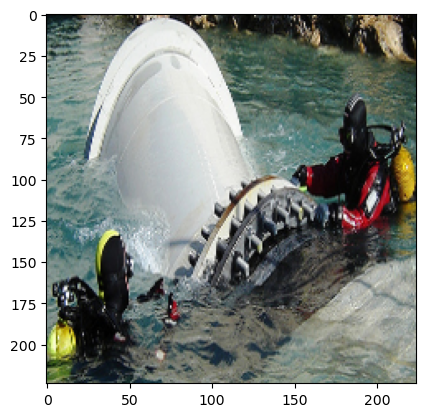

In [52]:
model.eval()
model.cpu()
i=4003
test_demo = model.greedy_decode(test_decoder_dataset[i][0].unsqueeze(0))
print(f'Real caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {vectorizer.decode(test_demo)}')
plt.imshow(test_decoder_dataset[i][0].int().permute(1, 2, 0))

Real caption: <SOS> молодой человек ждет на ступеньках остановившегося троллейбуса в <UNK> <EOS>
Predict: <SOS> пассажирский поезд стоящий на железнодорожной станции рядом с пешеходным переходом <EOS>


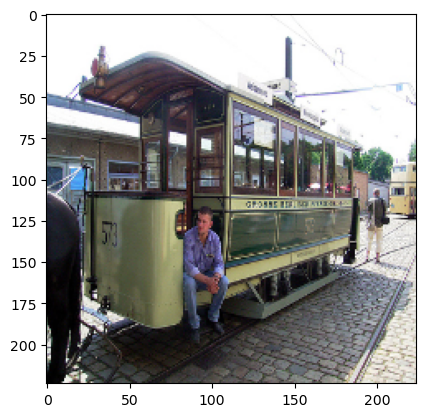

In [139]:
test_demo = model.beam_decode(test_decoder_dataset[i][0].unsqueeze(0), beam_width=2)
print(f'Real caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {vectorizer.decode(torch.concat(test_demo[0][0]))}')
plt.imshow(test_decoder_dataset[i][0].int().permute(1, 2, 0))

<SOS> собака бегущая по траве с открытой пастью и высунутым языком <EOS>


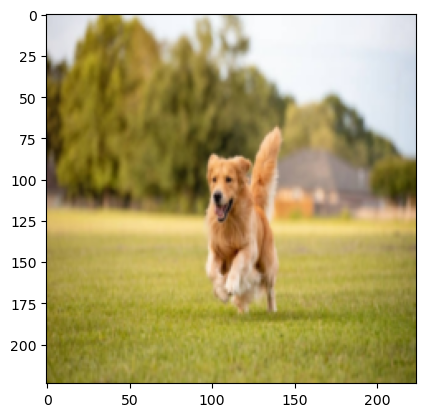

In [23]:
import torchvision

image = transforms.Resize((224, 224))(torchvision.io.read_image('../../temp1.jpg')).float()
print(vectorizer.decode(model.greedy_decode(image.unsqueeze(0))))
plt.imshow(image.int().permute(1, 2, 0))

In [54]:
model.eval()
model.cpu()

outputs = []
captions = []

for idx in tqdm(range(len(test_decoder_dataset))):
    caption = list(filter(lambda x: x != vectorizer.padding_idx, test_decoder_dataset[idx][1].tolist()))
    output = model.greedy_decode(test_decoder_dataset[idx][0].unsqueeze(0))
    outputs.append((idx, output))
    captions.append((idx, caption))

100%|████████████████████████████████████████████████████████████████████████████| 17998/17998 [51:33<00:00,  5.82it/s]


In [69]:
len(outputs)

15661

In [55]:
def iou_score(outputs, captions):
    iou = 0
    for i in range(len(outputs)):
        iou += len(set(outputs[i][1]) & set(captions[i][1]))/len(set(outputs[i][1]) | set(captions[i][1]))
    return iou / len(captions)
iou_score(outputs, captions)

0.18207827417512623

In [56]:
import nltk
f = nltk.translate.bleu_score.SmoothingFunction().method3
scores = [nltk.translate.bleu_score.sentence_bleu([captions[i][1]], outputs[i][1], smoothing_function=f) for i in range(len(captions))]
print(max(scores))
print(sum(scores)/len(captions))

1.0
0.05470853882683352


In [57]:
scores = [nltk.translate.meteor_score.meteor_score([vectorizer.decode(captions[i][1]).split()], vectorizer.decode(outputs[i][1]).split()) for i in range(len(captions))]
print(max(scores))
print(sum(scores)/len(captions))

0.9997724169321802
0.1794669595816913


In [59]:
import numpy as np

In [60]:
indexes = np.array(list(map(lambda x: x[0], captions)))

In [60]:
np.argsort(np.array(scores))[::-1][:200]

array([11216, 12655, 13146, 13111, 13118, 13121, 13123, 13129, 13130,
       13136, 15055, 15048, 15794, 13151, 15841, 13153, 15790, 13182,
       13184, 15047, 13185, 13192, 13195, 13201, 15374, 13203, 15066,
       13107, 15068, 13091, 12967, 15838, 12973, 12978, 12985, 12989,
       12993, 12998, 13000, 13025, 13029, 13034, 13044, 13054, 15818,
       13056, 13067, 15815, 13074, 13084, 13085, 15811, 13087, 13211,
       13218, 15376, 15735, 13450, 13451, 13452, 13459, 15019, 13471,
       13473, 13483, 13495, 13497, 13502, 13505, 13520, 13524, 13527,
       15716, 15715, 13531, 15018, 15710, 13563, 13575, 13581, 13440,
       13431, 13241, 13429, 13250, 15770, 13253, 15768, 13270, 15763,
       15761, 13283, 13289, 13298, 13314, 13319, 15026, 13352, 13355,
       13356, 13361, 15747, 13373, 15744, 13404, 15742, 13424, 12962,
       12957, 13593, 12551, 15975, 12518, 12519, 15972, 12525, 12527,
       15108, 12531, 12538, 12541, 12546, 12562, 15843, 12563, 12572,
       15950, 12587,

In [61]:
temp = indexes[np.argsort(np.array(scores))[::-1][:1000]]

In [ ]:
for i in range(len(temp)):
    t = temp[i]
    plt.imshow(test_decoder_dataset[t][0].int().permute(1, 2, 0))
    plt.title(vectorizer.decode(outputs[np.argsort(np.array(scores))[::-1][i]][1]))
    plt.show()

In [87]:
np.argsort(np.array(scores))[::-1][i]

7113

In [88]:
scores[7113]

0.40917431192660547

Predict: <SOS> группа людей катается на лыжах по заснеженной улице <EOS>
True: <SOS> группа женщин в снегу на лыжах пытается выиграть гонку <EOS>


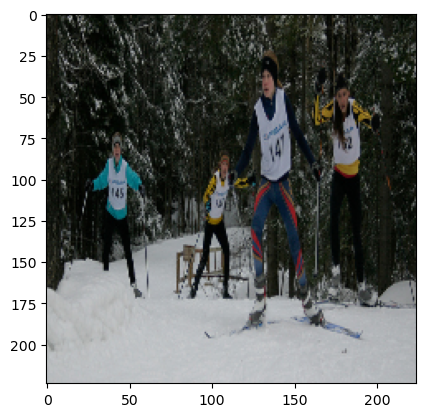

In [86]:
i = 806
t = temp[i]
plt.imshow(test_decoder_dataset[t][0].int().permute(1, 2, 0))
print(f'Predict:', vectorizer.decode(outputs[np.argsort(np.array(scores))[::-1][i]][1]))
print(f'True:', vectorizer.decode(captions[np.argsort(np.array(scores))[::-1][i]][1]))
plt.show()

In [85]:
np.argsort(np.array(scores))[::-1][i+1600]

10877

In [28]:
import json

with open(f'{name}_metric.json', 'w') as file:
    json.dump({'captions': captions, 'outputs': outputs}, file)

In [29]:
with open(f'{name}_results.json', 'w') as file:
    json.dump({'captions': [vectorizer.decode(caption) for caption in captions], 'outputs': [vectorizer.decode(output) for output in outputs]}, file)